# Notebook for Cyclic annealing with word dropout LSTM VAE

# Set up notebook

In [13]:
!nvidia-smi

Fri Jan  3 15:20:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    813MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [14]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 4.7MB/s 


In [15]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import modules

In [0]:
# import model
from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, get_latent_representation, getActiveUnits

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
data_dict = pickle.load( open( root_path + "FREM_data_set_sub10.p", "rb" ))

In [19]:
data_dict.keys()

dict_keys(['EM', 'FR'])

dict_keys(['EM', 'FR'])

In [20]:
print(f"train formal len: {len(data_dict['FR']['train']['formal'] + data_dict['EM']['train']['formal'])}")
print(f"train informal len: {len(data_dict['FR']['train']['informal'] + data_dict['EM']['train']['informal'] )}")
print(f"test formal len: {len(data_dict['FR']['test']['formal'] + data_dict['EM']['train']['formal'] )}")
print(f"test informal len: {len(data_dict['FR']['test']['informal'] + data_dict['EM']['train']['informal'])}")

train formal len: 27640
train informal len: 27640
test formal len: 15163
test informal len: 15163
train formal len: 27640
train informal len: 27640
test formal len: 15163
test informal len: 15163


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'fulltraintest32000.model')
VOCAB_SIZE = 32000

# Setting up model Model

### model

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
BATCH_SIZE = 1024
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader
training_data = data_dict['EM']['train']['formal'] + data_dict['EM']['train']['informal'] + data_dict['FR']['train']['formal'] + data_dict['FR']['train']['informal']
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data = data_dict['EM']['test']['formal'] + data_dict['FR']['test']['formal'] + data_dict['EM']['test']['informal'] + data_dict['FR']['test']['informal'] 
test_data_loader = DataLoader(test_data, batch_size= BATCH_SIZE)

### Optimizer

In [0]:
optimizer = optim.Adam(rnn_vae.parameters(),lr= 0.0006)

### Training and test functions

In [0]:
def train(epoch):
    rnn_vae.train()
    epoch_loss = 0
    epoch_bce = 0
    epoch_kld = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output, mu, logvar = rnn_vae.forward(sentence)
        loss, BCE, KLD = ELBO_cAnneal(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar, epoch=epoch, cyclic=100)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_bce += BCE
        epoch_kld += KLD
    epoch_loss /= N_train
    epoch_bce /= N_train
    epoch_kld /= N_train
    return epoch_loss, epoch_bce, epoch_kld


def test(epoch):
    rnn_vae.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      epoch_bce = 0
      epoch_kld = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output, mu, logvar = rnn_vae.forward(sentence)
          loss, BCE, KLD = ELBO_cAnneal(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar, epoch=epoch, cyclic=100)
          epoch_loss += loss.item()
          epoch_bce += BCE
          epoch_kld += KLD
      epoch_loss /= N_test
      epoch_bce /= N_test
      epoch_kld /= N_test
    return epoch_loss, epoch_bce, epoch_kld

## Training loop

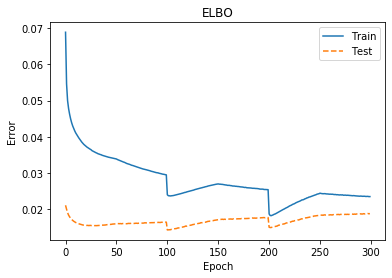

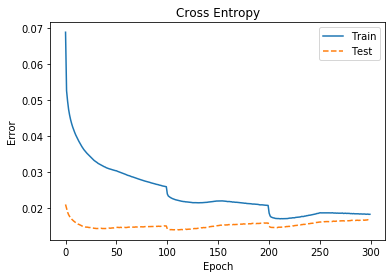

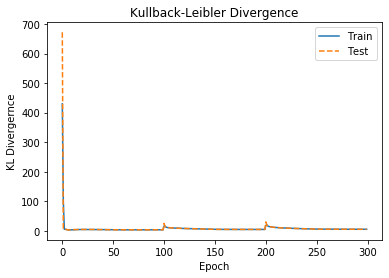

Epoch 299: time: 15.065347909927368
train: loss: 0.023487461872625282 BCE: 0.018350977450609207 KLD: 5.2582550048828125
test: loss: 0.018786651323426443 BCE: 0.01682421937584877 KLD: 5.200443267822266


In [22]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(N_epochs//2):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

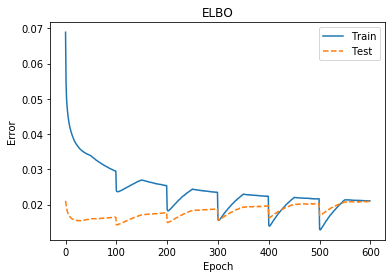

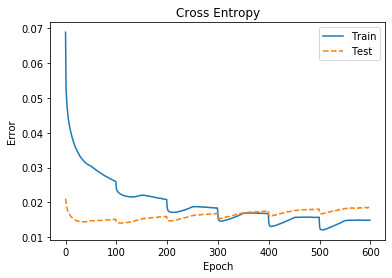

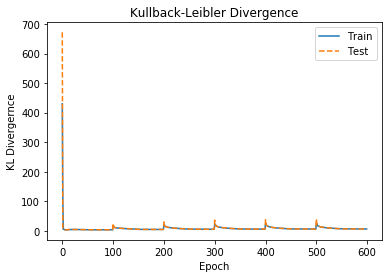

Epoch 599: time: 15.13906717300415
train: loss: 0.02108382740517601 BCE: 0.014880617149174213 KLD: 6.350259780883789
test: loss: 0.02094074321242998 BCE: 0.01857508160173893 KLD: 6.269004821777344


In [29]:
for epoch in range(N_epochs//2, N_epochs):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(rnn_vae.state_dict(), root_path + "trained_models/" + "cyc_wd_model_fulldata.pt")

#### Optional load model

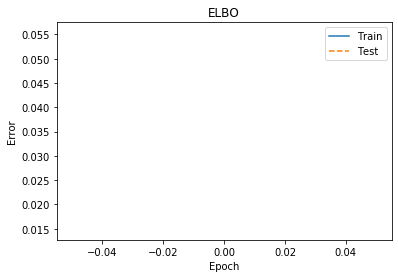

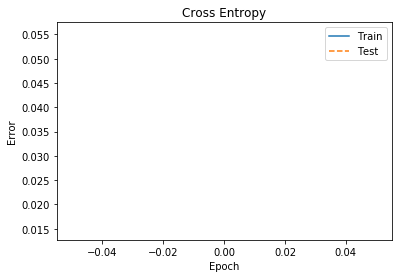

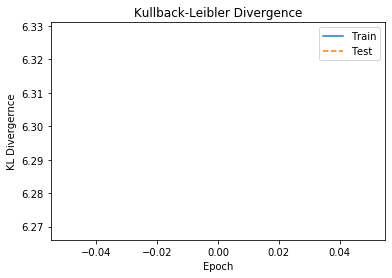

Epoch 0: time: 15.058818578720093
train: loss: 0.014751182606527326 BCE: 0.014751184731721878 KLD: 6.3280930519104
test: loss: 0.05544054139335201 BCE: 0.05544054135680199 KLD: 6.26900577545166


In [26]:
rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                 latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()

rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "cyc_wd_model_fulldata.pt"))

N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(1):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

# Model evaluation

#### ELBO, CBE and KL Divergence of trained model

In [27]:
print(f"ELBO \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")
print(f"Cross Entropy \nTrain: {train_bce_arr[-1]} Test: {test_bce_arr[-1]}")
print(f"KL Divergence \nTrain: {train_kld_arr[-1]} Test: {test_kld_arr[-1]}")

ELBO 
Train: 0.014751182606527326 Test: 0.05544054139335201
Cross Entropy 
Train: 0.014751184731721878 Test: 0.05544054135680199
KL Divergence 
Train: 6.3280930519104 Test: 6.26900577545166


In [28]:
active_units, test_vars = getActiveUnits(rnn_vae, test_data_loader, delta=0.01)
print(f"Active units: {active_units.cpu().numpy()}")
print(f"Variances: \n{test_vars.cpu().detach().numpy()}")

Active units: 6
Variances: 
[[7.48785314e-05 6.25777466e-05 3.90093833e-01 2.08375684e-04
  1.35370836e-04 1.53452711e-04 8.53759702e-05 5.69394360e-05
  5.89659285e-05 1.11629735e-04 6.50827351e-05 5.77728169e-05
  9.41594660e-01 6.40267608e-05 5.28135351e-05 7.41065087e-05
  1.11141118e-04 4.16140065e-05 7.27297374e-05 7.44676072e-05
  6.42921805e-05 1.41311393e-04 8.32050573e-05 1.06396117e-04
  3.08028460e-01 6.60320511e-05 1.05991836e-04 6.32874071e-05
  7.56090594e-05 2.02851865e-04 7.65990844e-05 6.41013539e-05
  7.84825563e-01 8.09318954e-05 6.01961692e-05 1.38724790e-04
  8.59724532e-05 8.97868085e-05 8.67559138e-05 8.67324634e-05
  8.33908634e-05 9.26281929e-01 5.42689377e-05 1.01399979e-04
  9.08212387e-05 7.90337144e-05 4.70059931e-05 5.51855665e-05
  8.86780500e-01 4.65692028e-05 4.00090066e-05 9.46639921e-05
  7.08439038e-05 1.00322563e-04 9.08980946e-05 1.17137271e-04
  7.85800294e-05 1.16201809e-04 4.59202201e-05 6.51773007e-05
  8.66673217e-05 6.76319032e-05 1.18838871

#### reconstructing sentences from training set

In [33]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: they are the best band ever!
Generated sentence: i had a rockin time .

*******
Real sentence: go to myspace.com and click on music.
Generated sentence: try the second man for the end!..

*******
Real sentence: i love my boyfriend, and he loves me.
Generated sentence: i your number and i love that movie!

*******
Real sentence: if its too many then spare him.
Generated sentence: and she was something i thought.

*******
Real sentence: the characters are very similar, trust me.
Generated sentence: the product comes around in those two.

*******
Real sentence: my husband and i are both 28 years old.
Generated sentence: bow wow said i forgot- watch "i."

*******
Real sentence: a white cat in a blender.
Generated sentence: disliked men in black men.

*******
Real sentence: take both of them to admire brokeback mountain.
Generated sentence: with a negative attitude like that, yes.

*******
Real sentence: i will add this to my waiting list.
Generated sentence: i did not like i

#### reconstructing sentences from test set

In [34]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=test_data_loader)
  print('*******')

Real sentence: there's nothing he needs to change.
Generated sentence: there aren't many nobody with another.

*******
Real sentence: it does not exist.
Generated sentence: it is hard to guess

*******
Real sentence: what differentiates a mosquitoo from a blonde?
Generated sentence: what if i mixed in the movie the craft?

*******
Real sentence: i am watching it right now.
Generated sentence: i suppose it matches the couple.

*******
Real sentence: in my time, emo was a comedian.
Generated sentence: dr. dre was in a career.

*******
Real sentence: what did the beaver say to the log?
Generated sentence: what is up with? z will .

*******
Real sentence: it offends everyone equally.
Generated sentence: she is beautiful right.

*******
Real sentence: what exactly are you stating?
Generated sentence: what restaurants are you going?

*******
Real sentence: until the show's next season.
Generated sentence: yeah, im a horror movie fanatic!!

*******
Real sentence: my little brother would ask a